# Image Captioning

>It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order.

### Photo and Caption Dataset

>Dataset used for image captioning is the Flickr8K dataset.

>Collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events.

>The dataset has a pre-defined training dataset (6,000 images), development dataset (1,000 images), and test dataset (1,000 images).

### Importing Libraries

> Libraries required to run the project

In [1]:
from os import listdir
import string
from pickle import dump
from pickle import load
from numpy import array
from numpy import argmax
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from matplotlib import pyplot as plt

Using TensorFlow backend.


# **Prepare Photo Data**

>We will use a pre-trained model to interpret the content of the photos.
    
>In this case, we will use the Oxford Visual Geometry Group, or VGG, model that won the ImageNet competition in 2014.
    
>We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration is redundant.
    
>Instead, we can pre-compute the photo features using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset.
    
>We can load the VGG model in Keras using the VGG class. We will remove the last layer from the loaded model, as this is the model used to predict a classification for a photo. We are not interested in classifying images, but we are interested in the internal representation of the photo right before a classification is made. These are the features that the model has extracted from the photo.

#### Extract features from each photo in the directory

>Function named extract_features()
                >>will load each photo, prepare it for VGG
                ,collect the predicted features from the VGG model. 
                The image features are a 1-dimensional 4,096 element vector.

>The function returns a dictionary of image identifier to image features.

In [2]:
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

#### Extract features from all images

In [3]:
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

>1206506157_c7956accd5.jpg
>1207159468_425b902bfb.jpg
>1211015912_9f3ee3a995.jpg
>1213336750_2269b51397.jpg
>1215334959_b1970965f7.jpg
>121800200_bef08fae5f.jpg
>121971540_0a986ee176.jpg
>1220401002_3f44b1f3f7.jpg
>1222322358_225067636e.jpg
>1224851143_33bcdd299c.jpg
>1225443522_1633e7121f.jpg
>1227655020_b11a1bb112.jpg
>1229756013_94663527d7.jpg
>1231229740_8dcbf80bfb.jpg
>1232148178_4f45cc3284.jpg
>1234293791_6566284bcd.jpg
>1234817607_924893f6e1.jpg
>1235580648_7eebaed9bc.jpg
>1235681222_819231767a.jpg
>1235685934_be89b231fb.jpg
>1236951314_0308dc4138.jpg
>1236964638_1808784a3c.jpg
>1237985362_dbafc59280.jpg
>123889082_d3751e0350.jpg
>123997871_6a9ca987b1.jpg
>1240297429_c36ae0c58f.jpg
>124195430_d14028660f.jpg
>1244140539_da4804d828.jpg
>1244306891_8e78ae1620.jpg
>1244485675_822e6efe60.jpg
>1245022983_fb329886dd.jpg
>1247181182_35cabd76f3.jpg
>1248357227_2b4175fc39.jpg
>1248734482_3038218f3b.jpg
>124881487_36e668145d.jpg
>1248940539_46d33ed487.jpg
>1248953128_24c9f8d924.jpg
>124972

>1452361926_6d8c535e32.jpg
>1453366750_6e8cf601bf.jpg
>1454678644_7e5a371301.jpg
>1454841725_4b6e6199e2.jpg
>1456393634_74022d9056.jpg
>1456630952_dd4778a48f.jpg
>145721496_687af9bb18.jpg
>145721498_a27d2db576.jpg
>1457762320_7fe121b285.jpg
>1459032057_97e73ed6ab.jpg
>1459250022_bf1eddad11.jpg
>1460352062_d64fb633e0.jpg
>1460500597_866fa0c6f3.jpg
>146098876_0d99d7fb98.jpg
>146100443_906d87faa2.jpg
>1461329041_c623b06e5b.jpg
>1461653394_8ab96aae63.jpg
>1461667284_041c8a2475.jpg
>1463638541_c02cfa04dc.jpg
>1463732130_a754441289.jpg
>1463732807_0cdf4f22c7.jpg
>1464120327_d90279ca3a.jpg
>1465666502_de289b3b9c.jpg
>146577645_91b570c0d0.jpg
>146577646_9e64b8c2dc.jpg
>1466307485_5e6743332e.jpg
>1466307489_cb8a74de09.jpg
>1466479163_439db855af.jpg
>1467533293_a2656cc000.jpg
>1468103286_96a6e07029.jpg
>1468389504_c724bdcad0.jpg
>1468429623_f001988691.jpg
>1468962616_5803b4397f.jpg
>1469000260_5d473c8283.jpg
>1469358746_2a879abaf3.jpg
>1470061031_4cb59c12a8.jpg
>1470132731_fa416b7504.jpg
>147053

>19212715_20476497a3.jpg
>1921398767_771743bf4e.jpg
>1923476156_e20976b32d.jpg
>1924234308_c9ddcf206d.jpg
>1925434818_2949a8f6d8.jpg
>1926129518_4350f4f552.jpg
>1928319708_ccf1f4ee72.jpg
>1931690777_897a7d8ab6.jpg
>1932161768_996eadac87.jpg
>1932314876_9cc46fd054.jpg
>1936215201_d03a75cbba.jpg
>1937104503_313d22a2d0.jpg
>1937262236_cbf5bfa101.jpg
>1947351225_288d788983.jpg
>195084264_72fb347b0f.jpg
>1952896009_cee8147c90.jpg
>1956678973_223cb1b847.jpg
>1956944011_c5661d3f22.jpg
>1957371533_62bc720bac.jpg
>195962284_e57178054a.jpg
>195962790_3380aea352.jpg
>1962729184_6996e128e7.jpg
>1965278563_8279e408de.jpg
>1969573381_5ecfae4c80.jpg
>197107117_4b438b1872.jpg
>197142902_f05ff198c2.jpg
>197504190_fd1fc3d4b7.jpg
>1975171469_84e425f61b.jpg
>1975531316_8b00eeaaf7.jpg
>1977827746_4e13d7e19f.jpg
>197924859_f6e39a7dfa.jpg
>1980315248_82dbc34676.jpg
>1980882959_9a161f3469.jpg
>1982852140_56425fa7a2.jpg
>1984936420_3f3102132b.jpg
>1989145280_3b54452188.jpg
>1991806812_065f747689.jpg
>199441686

>2148013097_6a4f495bc5.jpg
>2148695079_9ae6a9b1c7.jpg
>2148916767_644ea6a7fa.jpg
>2148991939_3b9fd6c439.jpg
>2149968397_a7411729d1.jpg
>2149982207_5345633bbf.jpg
>2150564996_d173a506d7.jpg
>2151056407_c9c09b0a02.jpg
>2151300603_248a9fe715.jpg
>215214751_e913b6ff09.jpg
>2156131463_5b53636cf0.jpg
>2156726763_034ecd2e39.jpg
>2157003092_eaeb977789.jpg
>2157173498_2eea42ee38.jpg
>2158247955_484f0a1f11.jpg
>2158267555_db1d94e468.jpg
>215876547_fa584c5ec3.jpg
>2159447283_fab8c272b0.jpg
>2160266952_a2ab39191b.jpg
>216172386_9ac5356dae.jpg
>2161799386_27aa938421.jpg
>2162469360_ff777edc95.jpg
>2162564553_96de62c7e6.jpg
>2164363131_6930455d45.jpg
>2165459064_5b81ff23eb.jpg
>2165461920_1a4144eb2b.jpg
>2165677531_e1d5e086f7.jpg
>2167644298_100ca79f54.jpg
>2169067981_cc19268f23.jpg
>2169951750_495820a215.jpg
>2170187328_65c2f11891.jpg
>2170222061_e8bce4a32d.jpg
>2171154778_8189169336.jpg
>2171576939_d1e72daab2.jpg
>2171891283_dedd9cf416.jpg
>2172493537_128bc8b187.jpg
>2172526745_649f420569.jpg
>217

>2273105617_7c73d2d2d3.jpg
>2273591668_069dcb4641.jpg
>2273799395_5072a5736d.jpg
>2273871383_1ddb3562ea.jpg
>2274602044_b3d55df235.jpg
>2274992140_bb9e868bb8.jpg
>2275029674_6d4891c20e.jpg
>2275253272_00f941366e.jpg
>2275372714_017c269742.jpg
>2276120079_4f235470bc.jpg
>2276314067_7ee246f859.jpg
>2276499757_b44dc6f8ce.jpg
>2277081067_d2b4c98bce.jpg
>2277299634_e14bdb7ff7.jpg
>2278110011_ba846e7795.jpg
>2278766574_f71f1704a8.jpg
>2278776373_fe499a93be.jpg
>2279496715_8ef3ee6edb.jpg
>2279945145_8815c59217.jpg
>2279980395_989d48ae72.jpg
>2280354512_c0d035d53f.jpg
>2280525192_81911f2b00.jpg
>2281006675_fde04e93dd.jpg
>2281054343_95d6d3b882.jpg
>2281075738_230892b241.jpg
>2281768510_9cc5728c55.jpg
>2282043629_91b7831352.jpg
>2282260240_55387258de.jpg
>2282522980_45cfa8e0cf.jpg
>2282600972_c22d1e03c7.jpg
>2282895743_f803f1cf01.jpg
>2283966256_70317e1759.jpg
>2284239186_c827f4defa.jpg
>2284894733_b710b9b106.jpg
>2285152690_3fb93f65f1.jpg
>2285570521_05015cbf4b.jpg
>2285741931_07159a21f2.jpg
>

>2393911878_68afe6e6c1.jpg
>2393924525_1bf45ca217.jpg
>2393971707_bce01ae754.jpg
>2394003437_184a838aa9.jpg
>2394267183_735d2dc868.jpg
>239453674_0df7767208.jpg
>2394763838_99d1435b85.jpg
>2394824046_51cec8e5e7.jpg
>2394857899_76bfdf720b.jpg
>2394919002_ed7527ff93.jpg
>2394922193_310166d6af.jpg
>2395967330_7e6ea404f6.jpg
>2396025708_e4a72e2558.jpg
>2396100671_3a9d67f03d.jpg
>2396669903_5217a83641.jpg
>2396691909_6b8c2f7c44.jpg
>2396746868_0727e06983.jpg
>239807547_4923efc821.jpg
>2398605966_1d0c9e6a20.jpg
>2399114095_c3196ff456.jpg
>2399219552_bbba0a9a59.jpg
>2399551242_c62a46dd5f.jpg
>2400958566_4e09424046.jpg
>2402462857_7684848704.jpg
>2402744031_11f9f2f2b8.jpg
>2402793046_3385554e81.jpg
>2403078014_4b1d6f8bde.jpg
>2403376030_903521c371.jpg
>2403544744_cba152f5c1.jpg
>2404488732_ca1bbdacc2.jpg
>2404520067_87798dbaee.jpg
>2404692474_37da774368.jpg
>2405599120_ec5f32af6f.jpg
>240583223_e26e17ee96.jpg
>2405978603_6221b0c2e7.jpg
>2406591500_403f145905.jpg
>240696675_7d05193aa0.jpg
>2407

>2472896179_245e7d142f.jpg
>2472980433_210ec62874.jpg
>2473293833_78820d2eaa.jpg
>2473689180_e9d8fd656a.jpg
>2473737724_355599a263.jpg
>2473738924_eca928d12f.jpg
>2473791980_805c819bd4.jpg
>2474047296_fd9179d438.jpg
>2474092890_6c0781a8ed.jpg
>2474918824_88660c7757.jpg
>2475162978_2c51048dca.jpg
>2475300106_b8563111ba.jpg
>247617035_9f2e821534.jpg
>247617754_4b1137de8c.jpg
>247618600_239eeac405.jpg
>247619370_a01fb21dd3.jpg
>2476214153_99a3998509.jpg
>247637795_fdf26a03cf.jpg
>247652942_29ede19352.jpg
>247691240_3881777ab8.jpg
>247704641_d883902277.jpg
>247706586_7e25c7adf8.jpg
>2477121456_1ac5c6d3e4.jpg
>2477623312_58e8e8c8af.jpg
>247778426_fd59734130.jpg
>2478929971_9eb6c074b6.jpg
>2479162876_a5ce3306af.jpg
>2479180530_7ebba2d8bf.jpg
>2479553749_f7ac031940.jpg
>2479652566_8f9fac8af5.jpg
>2480021389_dda9fb2818.jpg
>2480327661_fb69829f57.jpg
>2480664591_e6d22ed61c.jpg
>2480668859_6f9b46be6a.jpg
>2480820830_bdec1f5b76.jpg
>2480832276_fa55480ecb.jpg
>2480850054_de3433b54a.jpg
>2481003841

>257588281_39e1c9d929.jpg
>2576878141_87f25a10f0.jpg
>2577972703_a22c5f2a87.jpg
>2578003921_e23b78e85f.jpg
>2578161080_e007c9177a.jpg
>2578289278_01516d23a0.jpg
>2578395598_6982734d46.jpg
>2578834476_118585730d.jpg
>2579266054_1ec58aa92f.jpg
>2579268572_d78f8436cb.jpg
>2579460386_94c489028d.jpg
>2579572274_826598b14a.jpg
>2579899436_5086a33c7a.jpg
>2580215443_4e64afe3d5.jpg
>2581066814_179d28f306.jpg
>2582390123_71120edb0c.jpg
>2583001715_1ce6f58942.jpg
>2584020755_14e2b3e8fc.jpg
>2584412512_6767593f24.jpg
>2584487952_f70e5aa9bf.jpg
>258476074_f28f4a1ae6.jpg
>2584957647_4f9235c150.jpg
>2585141045_b496a7b7c4.jpg
>2586028627_ddd054d8cc.jpg
>2586532797_dcf22a5021.jpg
>2586911841_41b7a48c91.jpg
>2587017287_888c811b5a.jpg
>2587106431_1cc0e719c6.jpg
>2587696611_db0378710f.jpg
>2587818583_4aa8e7b174.jpg
>2587846523_b177c9a3e3.jpg
>2588456052_8842b47005.jpg
>2588625139_fdf6610218.jpg
>2588927489_f4da2f11ec.jpg
>2589156742_c46bc82137.jpg
>2589241160_3832440850.jpg
>2589308405_e208b5e745.jpg
>25

>2677656448_6b7e7702af.jpg
>267836606_bbea2267c8.jpg
>2678612999_893ed671f8.jpg
>2678798732_2998f9969c.jpg
>2679565682_91ecd283ff.jpg
>2679851489_a58780291e.jpg
>2679926555_b11cf45595.jpg
>2680619645_ab6645218d.jpg
>2680990587_eee6bd04fb.jpg
>2681215810_00b0642f7b.jpg
>2682194299_92005b26c6.jpg
>2682382530_f9f8fd1e89.jpg
>268365231_a0acecdc45.jpg
>2683963310_20dcd5e566.jpg
>2683985894_167d267dcb.jpg
>2684322797_85406f571d.jpg
>2684323357_c7a6d05d05.jpg
>2684489465_32ba1d0344.jpg
>2685139184_4ff45e0f76.jpg
>2685752892_9d5cd7f274.jpg
>2685788323_ceab14534a.jpg
>2686432878_0697dbc048.jpg
>268654674_d29e00b3d0.jpg
>268704620_8a8cef4cb3.jpg
>2687229880_97cfd8148e.jpg
>2687328779_b4356dab16.jpg
>2687529141_edee32649e.jpg
>2687539673_d54a8dc613.jpg
>2687672606_275169c35d.jpg
>2688102742_885e578a3f.jpg
>2688902319_52ceaf4a2a.jpg
>2689001252_e0016c89f0.jpg
>2689163361_4939875be5.jpg
>2689358407_9932f1b20c.jpg
>2689491604_d8760f57b4.jpg
>2690538407_7ca157be85.jpg
>2690702549_cf81da8cf6.jpg
>2691

>2783620390_02c166c733.jpg
>278388986_78ba84eb8f.jpg
>2784408839_53a25a21eb.jpg
>2784625888_71a421e171.jpg
>278496691_c1fd93e2d8.jpg
>2785108434_cd4a1c949c.jpg
>2785115802_137fa30000.jpg
>278559394_b23af734b9.jpg
>278608022_4175813019.jpg
>2786245676_0a69543832.jpg
>2786299623_a3c48bd318.jpg
>2787276494_82703f570a.jpg
>2787868417_810985234d.jpg
>2788628994_61123c03d2.jpg
>2788652511_4f10060e07.jpg
>2788945468_74a9618cfa.jpg
>2789238858_14261dd25a.jpg
>2789350645_96a2535b4d.jpg
>2789648482_1df61f224a.jpg
>2789688929_9424fceed1.jpg
>2789937754_5d1fa62e95.jpg
>2790909995_8b7a03d9d1.jpg
>2792195540_af5fb95caa.jpg
>2792212974_23b1ef05fa.jpg
>279230262_e541f9b670.jpg
>2792409624_2731b1072c.jpg
>2795287622_da187a3e86.jpg
>2795352290_9209b214f3.jpg
>279550225_d64d56158a.jpg
>2795866891_7559fd8422.jpg
>2796801478_8ebd7e550b.jpg
>2797149878_bb8e27ecf9.jpg
>2797185895_4d9e1e9508.jpg
>2797188545_aeb26c54c0.jpg
>279728508_6bd7281f3c.jpg
>2797438951_88a3ed7541.jpg
>2797511323_bf20acab45.jpg
>2798651

>2881087519_ca0aa79b2b.jpg
>2881441125_b580e3dd4b.jpg
>2881468095_d4ce8c0c52.jpg
>288177922_b889f2e1fe.jpg
>2882056260_4399dd4d7c.jpg
>2882483779_73c171ac19.jpg
>2882589788_cb0b407a8d.jpg
>2882743431_c3e6cd1b5c.jpg
>2882893687_1d10d68f2b.jpg
>2883099128_0b056eed9e.jpg
>2883324329_24361e2d49.jpg
>2883907436_82bf4a36b8.jpg
>2883950737_3b67d24af4.jpg
>2884092603_786b53a74b.jpg
>2884252132_5d8e776893.jpg
>2884301336_dc8e974431.jpg
>2884400562_e0851014fc.jpg
>2884420269_225d27f242.jpg
>2884651479_12e400ee58.jpg
>288508162_1727873924.jpg
>2885111681_dc328ecfff.jpg
>2885382946_f541ea5722.jpg
>2885387575_9127ea10f1.jpg
>2885891981_6b02620ae9.jpg
>2885912662_a3a2dfde45.jpg
>2886411666_72d8b12ce4.jpg
>2886533440_dfa832f2fa.jpg
>2886837407_a4510ab1ef.jpg
>2887103049_a867e74358.jpg
>2887171449_f54a2b9f39.jpg
>2887614578_ed7ba21775.jpg
>2887744223_029f2fd5fe.jpg
>2887750774_920eb171aa.jpg
>2887798667_ce761d45e8.jpg
>2888386138_578d21033a.jpg
>2888408966_376c195b3f.jpg
>2888658480_e922a3dec2.jpg
>28

>296873864_4de75de261.jpg
>2968885599_0672a5f016.jpg
>2969380952_9f1eb7f93b.jpg
>2970067128_8842ab3603.jpg
>2970183443_accd597e0a.jpg
>2970461648_fe14ba0359.jpg
>2971211296_2587c3924d.jpg
>2971298546_dd595cf297.jpg
>2971431335_e192613db4.jpg
>2971478694_79e46ea7e5.jpg
>297169473_d3974e0275.jpg
>297285273_688e44c014.jpg
>2972864304_481aeffe50.jpg
>2972929655_04233b5489.jpg
>2973269132_252bfd0160.jpg
>2973272684_4d63cbc241.jpg
>2973638173_0dc21fd443.jpg
>2974501005_346f74e5d8.jpg
>2974587819_742fb7c338.jpg
>2975018306_0e8da316f5.jpg
>2975073156_7543ed326f.jpg
>2975118353_5af5a5df54.jpg
>2975253472_0f0c2dea70.jpg
>2975807155_5a8610c297.jpg
>2976155358_b4dd4407cf.jpg
>2976350388_3984e3193d.jpg
>2976537455_f3988c2d46.jpg
>2976684095_ce7ccfd423.jpg
>2976946039_fb9147908d.jpg
>297724467_e8918a6f90.jpg
>2977246776_b14be8290d.jpg
>2977379863_2e8d7a104e.jpg
>2978024878_a45b282bf4.jpg
>2978236380_fb24c43f1e.jpg
>2978271431_f6a7f19825.jpg
>2978394277_4572967b97.jpg
>2978409165_acc4f29a40.jpg
>2978

>305199420_89f6ddd778.jpg
>3051998298_38da5746fa.jpg
>3052038928_9f53aa2084.jpg
>3052104757_d1cf646935.jpg
>3052196390_c59dd24ca8.jpg
>3053415073_5b667230ed.jpg
>3053743109_a2d780c0d2.jpg
>3053785363_50392f2c53.jpg
>3053813297_7ce5f87710.jpg
>3053916979_848d32261b.jpg
>3054200086_657d4398e8.jpg
>3054989420_3e755ca352.jpg
>3054997030_797096dd12.jpg
>3055716848_b253324afc.jpg
>3056530884_27766059bc.jpg
>3056569684_c264c88d00.jpg
>3057497487_57ecc60ff1.jpg
>305749904_54a612fd1a.jpg
>3057618932_3b80ae85de.jpg
>3057770908_3fd97f79f9.jpg
>3057862887_135c61816a.jpg
>3058439373_9276a4702a.jpg
>3058627443_1d57ff0a2c.jpg
>3060519665_4d6b9a51b2.jpg
>3060594966_030658d318.jpg
>3060969260_08f43e4f4f.jpg
>3061481868_d1e00b1f2e.jpg
>3062173277_bfb5ef4c45.jpg
>3062273350_fd66106f21.jpg
>306315650_e064f5c677.jpg
>306318683_5f1f875191.jpg
>3063544435_10516c6937.jpg
>3064097919_e536ab9693.jpg
>3064383768_f6838f57da.jpg
>3064716525_b8418d4946.jpg
>3065468339_4955e90fd3.jpg
>3065560742_f6e266ccd9.jpg
>3066

>313051099_1bb87d6c56.jpg
>3130970054_04a3865c43.jpg
>3131107810_7e9b96cddc.jpg
>3131160589_dc73c209b7.jpg
>3131632154_098f86f4cb.jpg
>3131990048_369b081021.jpg
>3132006797_04822b5866.jpg
>3132619510_7dfc947d25.jpg
>3132760860_3e743a935d.jpg
>3132832452_c354c6396c.jpg
>3132903412_b4780d0ccf.jpg
>3133044777_8cc930a4ec.jpg
>313326614_b2adbe59e0.jpg
>3133403457_95dfe11da1.jpg
>3133825703_359a0c414d.jpg
>3134092148_151154139a.jpg
>3134341610_3c55e373a7.jpg
>3134385454_4f1d55333f.jpg
>3134387321_3a253224c1.jpg
>3134387513_ceb75bea0a.jpg
>3134585858_a8c3493ca5.jpg
>3134586018_ae03ba20a0.jpg
>3134644844_493eec6cdc.jpg
>3135504530_0f4130d8f8.jpg
>3135826945_f7c741e5b7.jpg
>3136043366_b3f8607a0e.jpg
>3136404885_f4d8f1d15a.jpg
>3136674757_57406c305c.jpg
>3136688093_568b053bdf.jpg
>3137061312_eb5fdcf3fd.jpg
>3138399980_d6ab8b2272.jpg
>3138433655_ea1d59e5b7.jpg
>3138504165_c7ae396294.jpg
>3138562460_44227a35cf.jpg
>3138746531_f6b816c126.jpg
>3139118874_599b30b116.jpg
>3139160252_75109e9e05.jpg
>31

>3199460792_deef518c01.jpg
>3199645963_a681fe04f8.jpg
>3199895624_4f01798c6f.jpg
>3200120942_59cfbb3437.jpg
>320093980_5388cb3733.jpg
>3201427741_3033f5b625.jpg
>3201594926_cd2009eb13.jpg
>3201666946_04fe837aff.jpg
>3202255152_08973fa3d7.jpg
>3202360797_2084743e90.jpg
>3203453897_6317aac6ff.jpg
>3203707977_cc9448fecb.jpg
>3203742047_6a55065411.jpg
>3203872773_6c30f64be3.jpg
>3203878596_cbb307ce3b.jpg
>3203908917_53e53c03d1.jpg
>3204081508_0e7f408097.jpg
>3204354161_caf89ec784.jpg
>3204525212_d548c7fca7.jpg
>3204686006_88f04547b9.jpg
>3204712107_5a06a81002.jpg
>3204922011_185e48949a.jpg
>3205214191_29b42b9b09.jpg
>3205336477_037d4b6bd9.jpg
>3205754736_32c29b5208.jpg
>3205839744_24504ba179.jpg
>3206058778_7053ee6b52.jpg
>3206919175_e3a11b6874.jpg
>3206999917_e682672cbc.jpg
>3207264553_8cd4dcde53.jpg
>3207343907_995f7ac1d2.jpg
>3207358897_bfa61fa3c6.jpg
>3207654194_43d6bebd68.jpg
>3207676216_48478bce97.jpg
>3207775692_bb897d9afd.jpg
>3208032657_27b9d6c4f3.jpg
>3208074567_ac44aeb3f3.jpg
>3

>3259225196_750c4ce0f9.jpg
>3259228898_cefd04580b.jpg
>3259229498_2b5708c0c6.jpg
>3259231890_16fe167b31.jpg
>3259579174_30a8a27058.jpg
>3259666643_ae49524c81.jpg
>3259694057_fae7484b0a.jpg
>3259757648_71edb4347b.jpg
>3259883609_6a1b46919e.jpg
>3259991972_fce3ab18b2.jpg
>3259992164_94600858b3.jpg
>3259992638_0612a40288.jpg
>3259992722_4c5e895734.jpg
>3260088697_af9b6d2393.jpg
>3260191163_6c1551eee8.jpg
>3260214530_7179346407.jpg
>326028454_fb396167e6.jpg
>3260768565_2b725be090.jpg
>3260975858_75d0612a69.jpg
>3261493263_381a4c5cc7.jpg
>3261666285_86fceb762d.jpg
>3262075846_5695021d84.jpg
>3262301835_9f1a49b80a.jpg
>3262386960_14f5d857db.jpg
>3262475923_f1f77fcd9f.jpg
>3262647146_a53770a21d.jpg
>3262760716_1e9734f5ba.jpg
>3262793378_773b21ec19.jpg
>3262849619_0bc4f88ef9.jpg
>3263141261_db3a4798b5.jpg
>3263215700_e27f81f8b9.jpg
>326334188_8850b7bfd4.jpg
>3263395801_5e4cee2b9e.jpg
>3263497678_8bb688ca01.jpg
>3263741906_6e4508d1c8.jpg
>3263946591_a1558b77d3.jpg
>3264337159_e1680a35ba.jpg
>32

>3325974730_3ee192e4ff.jpg
>3326024473_4c16e4fbfc.jpg
>3326086533_23a0a54a8e.jpg
>3326204251_2f9e446a2f.jpg
>3326249355_e7a7c71f06.jpg
>3326273086_e09e845185.jpg
>3326376344_3306bf439e.jpg
>3326454455_960e5442e9.jpg
>3326588088_172d1b2584.jpg
>3327487011_1372c425fb.jpg
>3327563443_870a33f748.jpg
>3328247381_a9f7fb4898.jpg
>3328397409_092de2bd32.jpg
>3328495660_ed0e3f29cf.jpg
>3328535573_33c3cd5b59.jpg
>3328646934_5cca4cebce.jpg
>3329169877_175cb16845.jpg
>3329254388_27017bab30.jpg
>3329289652_e09b80e2f3.jpg
>3329777647_5e1fd503ac.jpg
>3329793486_afc16663cc.jpg
>3329858093_0ec73f2190.jpg
>3330007895_78303e8a40.jpg
>3330019493_fd36fbc2ea.jpg
>3330102093_1d6e35e78d.jpg
>333031366_a0828c540d.jpg
>3330333217_1a69497a74.jpg
>3330654550_3efe9a71af.jpg
>3330675488_8692476a4a.jpg
>3330680118_4e541889c1.jpg
>3330935489_9cb67ca36b.jpg
>3331009729_d3b14738e6.jpg
>3331102049_bc65cf6198.jpg
>3331190056_09f4ca9fd2.jpg
>3331525712_af1dcc47f2.jpg
>3331797838_b3e33dbe17.jpg
>3331900249_5872e90b25.jpg
>3

>3382303178_69b6d1bdd2.jpg
>3382679230_baef3d1eaa.jpg
>3383037991_8f07784b81.jpg
>3383388869_a14552e551.jpg
>3383491811_fd9d3a891d.jpg
>3383545083_1d7c95b003.jpg
>3384314832_dffc944152.jpg
>3384528359_e920154177.jpg
>3384742888_85230c34d5.jpg
>3385246141_a263d1053e.jpg
>3385593926_d3e9c21170.jpg
>3385956569_a849218e34.jpg
>3386060324_b98fdfa449.jpg
>3386375153_20c56d0aae.jpg
>3386893620_5f0bb4e794.jpg
>3386953179_84c2d7922f.jpg
>3387542157_81bfd00072.jpg
>3387630781_f421a94d9d.jpg
>3387661249_33e5ba0bc5.jpg
>3388094307_5a83be64a5.jpg
>3388330419_85d72f7cda.jpg
>3388836914_c267cf3a59.jpg
>3389321512_b11f499dab.jpg
>3389448506_7025e7cc12.jpg
>3391209042_d2de8a8978.jpg
>3391924827_53b31542ce.jpg
>3392019836_c7aeebca1c.jpg
>3392293702_ccb0599857.jpg
>3392851587_a638ff25e2.jpg
>3393035454_2d2370ffd4.jpg
>3393152604_27bd1037f2.jpg
>3393343330_b13df4d8ec.jpg
>3393394134_0caac47e1c.jpg
>3393446245_37dd3f3b59.jpg
>339350939_6643bfb270.jpg
>3393926562_66cc01b001.jpg
>3394070357_cb2a3243fc.jpg
>3

>3442844140_15aa45e9b8.jpg
>3442978981_53bf1f45f3.jpg
>3443030942_f409586258.jpg
>3443161359_65544fd732.jpg
>3443326696_fe0549c5be.jpg
>3443351431_7b4061df5c.jpg
>3443460885_46115463b4.jpg
>3443703471_14845d8850.jpg
>3443853670_6c79fcfcb2.jpg
>3444684583_6656e38088.jpg
>3444974984_963fb441a0.jpg
>3444982197_0ff15cc50b.jpg
>3445296377_1e5082b44b.jpg
>3445428367_25bafffe75.jpg
>3445544288_68fdb25969.jpg
>3446191973_1db572ed8a.jpg
>3446347599_0ecc49a9d5.jpg
>3446586125_cafa0bfd67.jpg
>3446762868_06e9d9d899.jpg
>3447007090_08d997833a.jpg
>3447155358_5b5b59b15e.jpg
>3447876218_4ccf42d7a0.jpg
>344841963_8b0fa9784c.jpg
>3448490813_f9623e864d.jpg
>3448855727_f16dea7b03.jpg
>3449114979_6cdc3e8da8.jpg
>3449170348_34dac4a380.jpg
>3449718979_e987c64e2d.jpg
>3449846784_278bc1ba92.jpg
>3450776690_38605c667d.jpg
>3450874870_c4dcf58fb3.jpg
>3451085951_e66f7f5d5c.jpg
>3451344589_6787bd06ef.jpg
>3451345621_fe470d4cf8.jpg
>3451523035_b61d79f6a8.jpg
>3451984463_37ac1ff7a8.jpg
>3452127051_fa54a902b3.jpg
>3

>3504158556_1d410c8ff7.jpg
>3504275465_604ce2ef34.jpg
>350443876_c9769f5734.jpg
>3504479370_ff2d89a043.jpg
>3504881781_6a842e043b.jpg
>3504940491_94c43792ed.jpg
>350529848_9569a3bcbc.jpg
>3505657604_8899161734.jpg
>350588129_6aef7b7fe2.jpg
>3506096155_13632955e8.jpg
>3506216254_04d119cac7.jpg
>3506468593_7e41a6d9f1.jpg
>3506560025_8d0f4f9ac4.jpg
>3506607642_40037b3fbf.jpg
>3506869953_802f463178.jpg
>3507076266_8b17993fbb.jpg
>3507670136_2e5f94accf.jpg
>3508051251_82422717b3.jpg
>3508522093_51f6d77f45.jpg
>3508637029_89f3bdd3a2.jpg
>3508882611_3947c0dbf5.jpg
>3509575615_653cbf01fc.jpg
>3509611207_7645b1d28d.jpg
>3510218982_318f738b76.jpg
>3510219078_670b6b3157.jpg
>3510695264_ef460fa6cc.jpg
>3511062827_cd87871c67.jpg
>3511890331_6163612bb9.jpg
>3512033659_7e8a0c2ffa.jpg
>3512033861_a357bb58b6.jpg
>3512127856_18a4c7aace.jpg
>3512791890_eb065b460a.jpg
>3513265399_a32e8cfd18.jpg
>3513362553_5fc5779e20.jpg
>3514019869_7de4ece2a5.jpg
>3514179514_cbc3371b92.jpg
>3514184232_b336414040.jpg
>351

>3562302012_0cbcd01ff9.jpg
>3562470436_6e193643ce.jpg
>3562816250_6e14d436b1.jpg
>3562903245_85071bb5f9.jpg
>3563059800_c073081ce3.jpg
>3563461991_de05537878.jpg
>3563668905_689ed479c5.jpg
>3563673070_71fa0903ed.jpg
>3563871276_c8b2a00df5.jpg
>3563924606_5914392cd8.jpg
>3564007203_df2b8010f1.jpg
>3564148252_aa4cb36a32.jpg
>3564157681_03a13b7112.jpg
>3564312955_716e86c48b.jpg
>3564385317_1bf5094068.jpg
>3564436847_57825db87d.jpg
>3564543247_05cdbc31cf.jpg
>3564738125_10400f69c0.jpg
>3564742915_5f940b95b4.jpg
>3564907603_14ccc655f1.jpg
>3565021218_d2bc1aa644.jpg
>3565598162_56044bc2f7.jpg
>3565654691_22b97d3994.jpg
>3565655045_8eb00b7423.jpg
>3565749152_7924d15b04.jpg
>3566111626_9a35a7b2c0.jpg
>3566225740_375fc15dde.jpg
>3567061016_62768dcce1.jpg
>3567214106_6ece483f8b.jpg
>3567604049_da9e1be4ba.jpg
>3568065409_1c381aa854.jpg
>3568197730_a071d7595b.jpg
>3568219100_dfbffddccd.jpg
>3568225554_73cdb19576.jpg
>3568505408_4e30def669.jpg
>3568605391_54ec367d88.jpg
>3569126684_a68b29a57f.jpg
>

>3626998066_3ae11ee278.jpg
>3627011534_485f667b10.jpg
>3627076769_3b71e73018.jpg
>3627216820_4952bacbcb.jpg
>3627290893_561e176e80.jpg
>3627676364_1dc9294ec5.jpg
>3627679667_0e3de9fc90.jpg
>3628017876_4ac27e687b.jpg
>3628043835_9d9bd595a7.jpg
>3628059004_5c3529b120.jpg
>3628103548_2708abcda2.jpg
>3628698119_5566769777.jpg
>3628994466_a12065d29b.jpg
>3629492654_619d7b67ee.jpg
>3629664676_36bcefe6b7.jpg
>3630102841_b4c3e00b2c.jpg
>3630332976_fdba22c50b.jpg
>3630641436_8f9ac5b9b2.jpg
>3630991662_990f397f7c.jpg
>3631023049_8a85bab19f.jpg
>3631136463_53ff624b82.jpg
>3631344685_ed0f3e091b.jpg
>3631474374_e40764d153.jpg
>3631671718_d712821757.jpg
>3631810528_7233c0f421.jpg
>3631986552_944ea208fc.jpg
>3632047678_f202609e50.jpg
>3632197966_0c5061025f.jpg
>3632225464_612d7b4c0f.jpg
>3632258003_6a0a69bf3a.jpg
>3632572264_577703b384.jpg
>3632842482_482f29e712.jpg
>3633396324_c4b24b1f51.jpg
>3634032601_2236676cdd.jpg
>3634281981_d9cf1d1a33.jpg
>3634400263_c6fcaa48e1.jpg
>3634785801_4b23184a06.jpg
>

>3691800116_6a7b315e46.jpg
>369186134_5eef374112.jpg
>369244499_752f0c1018.jpg
>3692593096_fbaea67476.jpg
>3692746368_ab7d97ab31.jpg
>3692836015_d11180727b.jpg
>3692892751_f6574e2700.jpg
>3693297007_94512e861e.jpg
>369360998_ba56fb436f.jpg
>3693961165_9d6c333d5b.jpg
>3694064560_467683205b.jpg
>3694071771_ce760db4c7.jpg
>3694093650_547259731e.jpg
>3694219419_a7a83d4886.jpg
>3694555931_7807db2fb4.jpg
>3694991841_141804da1f.jpg
>3695064885_a6922f06b2.jpg
>3695517194_2a6b604cb2.jpg
>3695949492_27ca3892fd.jpg
>3696246123_99d4d10140.jpg
>3696698390_989f1488e7.jpg
>3697003897_d8ac13be9a.jpg
>3697153626_90fb177731.jpg
>3697359692_8a5cdbe4fe.jpg
>3697378565_7060d9281a.jpg
>3697379772_40d831392b.jpg
>3697456750_460aea7252.jpg
>3697675767_97796334e4.jpg
>369802520_9825f2cd84.jpg
>3698607223_22fe09763a.jpg
>3698944019_825ef54f2f.jpg
>3699318394_6193f2c8e0.jpg
>3699522388_2333f01f40.jpg
>3699763582_f28c5130dd.jpg
>3700004668_99c3e3f55b.jpg
>3700322513_50f0d45bfa.jpg
>3700346840_bb80d622f7.jpg
>3700

>414773731_c3f5bf43d5.jpg
>415118186_64defc96f3.jpg
>415657941_454d370721.jpg
>415793623_6c1225ae27.jpg
>416106657_cab2a107a5.jpg
>416650559_cd08d3cd96.jpg
>416788726_5b4eb1466e.jpg
>416960865_048fd3f294.jpg
>416992999_654a99a903.jpg
>417577408_eb571658c1.jpg
>417966898_a04f9b5349.jpg
>418357172_bdddf71d32.jpg
>418616992_22090c6195.jpg
>418667611_b9995000f4.jpg
>418796494_bdb441de42.jpg
>419116771_642800891d.jpg
>41999070_838089137e.jpg
>420355149_f2076770df.jpg
>421153376_d1d325568f.jpg
>421316045_ae7a1eb4bc.jpg
>421322723_3470543368.jpg
>421706022_1ddb6a7a78.jpg
>421730441_6b2267fd31.jpg
>421808539_57abee6d55.jpg
>421932359_edbf181f44.jpg
>422756764_e7eaac76bf.jpg
>422763475_0bc814dac6.jpg
>423066487_07757b2b49.jpg
>424307754_1e2f44d265.jpg
>424379231_23f1ade134.jpg
>424416723_19c56cb365.jpg
>424506167_01f365726b.jpg
>424779662_568f9606d0.jpg
>424869823_7aec015d87.jpg
>425088533_a460dc4617.jpg
>425518464_a18b87c563.jpg
>425706089_f138118e12.jpg
>426065353_e9a604a01f.jpg
>426191845_1e

>498444334_a680d318a1.jpg
>498492764_fe276e505a.jpg
>498748832_941faaaf40.jpg
>498794783_cc2ac62b47.jpg
>498957941_f0eda42787.jpg
>50030244_02cd4de372.jpg
>500308355_f0c19067c0.jpg
>500446858_125702b296.jpg
>500678178_26ce0f4417.jpg
>501320769_31eea7b7ea.jpg
>501520507_c86f805ab8.jpg
>501650847_b0beba926c.jpg
>501684722_0f20c4e704.jpg
>501699433_f8df386cf9.jpg
>502115726_927dd684d3.jpg
>502671104_b2114246c7.jpg
>502783522_3656f27014.jpg
>502884177_25939ac000.jpg
>503090187_8758ab5680.jpg
>503717911_fc43cb3cf9.jpg
>503794526_603a7954d3.jpg
>504385521_6e668691a3.jpg
>504765160_b4b083b293.jpg
>504904434_889f426c6e.jpg
>505062117_a70b4e10ab.jpg
>505929313_7668f021ab.jpg
>505944126_f9a6ab8944.jpg
>505955292_026f1489f2.jpg
>506343925_b30a235de6.jpg
>506367606_7cca2bba9b.jpg
>506412121_67ecc7ec05.jpg
>506478284_7cf8bdbe36.jpg
>506738508_327efdf9c3.jpg
>506808265_fe84ada926.jpg
>506882688_b37d549593.jpg
>507758961_e63ca126cc.jpg
>508261758_78fb8ae067.jpg
>508432819_3d055f395d.jpg
>508929192_67

>688210930_85c5675d5b.jpg
>688940111_325a74674a.jpg
>689359034_4a64c24ca4.jpg
>689776124_07f560a920.jpg
>691770760_48ce80a674.jpg
>69189650_6687da7280.jpg
>693164706_9624582e69.jpg
>693450725_8ad72389e6.jpg
>693785581_68bec8312a.jpg
>694496803_f2a05869cf.jpg
>696663662_232edd58af.jpg
>69710411_2cf537f61f.jpg
>69710415_5c2bfb1058.jpg
>697490420_67d8d2a859.jpg
>697582336_601462e052.jpg
>697778778_b52090709d.jpg
>698107542_3aa0ba78b4.jpg
>700884207_d3ec546494.jpg
>701816897_221bbe761a.jpg
>707941195_4386109029.jpg
>707972553_36816e53a2.jpg
>708860480_1a956ae0f7.jpg
>708945669_08e7ffb9a7.jpg
>709373049_15b8b6457a.jpg
>70995350_75d0698839.jpg
>710878348_323082babd.jpg
>716597900_b72c58362c.jpg
>717673249_ac998cfbe6.jpg
>719837187_3e7bf1d472.jpg
>720208977_f44c2bba5b.jpg
>72218201_e0e9c7d65b.jpg
>724702877_f2a938766b.jpg
>72964268_d532bb8ec7.jpg
>732468337_a37075225e.jpg
>733172023_5810350af6.jpg
>733752482_ee01a419e5.jpg
>733964952_69f011a6c4.jpg
>733965014_1a0b2b5ee9.jpg
>735787579_617b047

In [4]:
# save to file
dump(features, open('features.pkl', 'wb'))

# Prepare Text Data

#### Load doc into memory

> load the file containing all of the descriptions.

In [3]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

>Each photo has a unique identifier. This identifier is used on the photo filename and in the text file of descriptions.

#### Extract descriptions for images

>we will step through the list of photo descriptions. Below defines a function load_descriptions() that, given the loaded document text, will return a dictionary of photo identifiers to descriptions. 

>Each photo identifier maps to a list of one or more textual descriptions.

In [4]:
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

#### Clean descriptions for images

>We will clean the text in the following ways in order to reduce the size of the vocabulary of words we will need to work with:

    Convert all words to lowercase.
    Remove all punctuation.
    Remove all words that are one character or less in length (e.g. ‘a’).
    Remove all words with numbers in them.
>Below defines the clean_descriptions() function that, given the dictionary of image identifiers to descriptions, steps through each description and cleans the text.

In [5]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

#### Convert the loaded descriptions into a vocabulary of words

>Once cleaned, we can summarize the size of the vocabulary.

>Ideally, we want a vocabulary that is both expressive and as small as possible. A smaller vocabulary will result in a smaller model that will train faster.

>For reference, we can transform the clean descriptions into a set and print its size to get an idea of the size of our dataset vocabulary.

In [6]:
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

#### Save descriptions to file, one per line

>Finally, we can save the dictionary of image identifiers and descriptions to a new file named descriptions.txt, with one image identifier and description per line.

>Below defines the save_descriptions() function that, given a dictionary containing the mapping of identifiers to descriptions and a filename, saves the mapping to file.

In [7]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [8]:
filename = 'Flickr8k_text/Flickr8k.token.txt'

#### load descriptions

In [9]:
doc = load_doc(filename)

#### parse descriptions

In [10]:
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


#### clean descriptions

In [11]:
clean_descriptions(descriptions)

#### summarize vocabulary

In [12]:
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8763


#### save to file

In [13]:
save_descriptions(descriptions, 'descriptions.txt')

## Develop Deep Learning Model

## Loading Data

>load the prepared photo and text data so that we can use it to fit the model.

>We are going to train the data on all of the photos and captions in the training dataset. While training, we are going to monitor the performance of the model on the development dataset and use that performance to decide when to save models to file.

>The train and development dataset have been predefined in the Flickr_8k.trainImages.txt and Flickr_8k.devImages.txt files respectively, that both contain lists of photo file names. From these file names, we can extract the photo identifiers and use these identifiers to filter photos and descriptions for each set.

>The function load_set() below will load a pre-defined set of identifiers given the train or development sets filename.

#### load a pre-defined list of photo identifiers

In [14]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

#### load clean descriptions into memory

>Now, we can load the photos and descriptions using the pre-defined set of train or development identifiers.

>Below is the function load_clean_descriptions() that loads the cleaned text descriptions from ‘descriptions.txt‘ for a given set of identifiers and returns a dictionary of identifiers to lists of text descriptions.

>The model we will develop will generate a caption given a photo, and the caption will be generated one word at a time. The sequence of previously generated words will be provided as input. Therefore, we will need a ‘first word’ to kick-off the generation process and a ‘last word‘ to signal the end of the caption.

>We will use the strings ‘startseq‘ and ‘endseq‘ for this purpose. These tokens are added to the loaded descriptions as they are loaded. It is important to do this now before we encode the text so that the tokens are also encoded correctly.

In [15]:
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

#### load photo features

>Function named load_photo_features() that loads the entire set of photo descriptions, then returns the subset of interest for a given set of photo identifiers.

In [16]:
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

#### covert a dictionary of clean descriptions to a list of descriptions

>to_lines() funtion is used to convert the dictionary of descriptions into a list of strings

In [17]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#### fit a tokenizer given caption descriptions

>create_tokenizer() function that will fit a Tokenizer given the loaded photo description text

In [18]:
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

#### create sequences of images, input sequences and output words for an image

>The function below named create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model. There are two input arrays to the model: one for photo features and one for the encoded text. There is one output for the model which is the encoded next word in the text sequence.

>The input text is encoded as integers, which will be fed to a word embedding layer. The photo features will be fed directly to another part of the model. The model will output a prediction, which will be a probability distribution over all words in the vocabulary.

>The output data will therefore be a one-hot encoded version of each word, representing an idealized probability distribution with 0 values at all word positions except the actual word position, which has a value of 1.

In [19]:
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

#### calculate the length of the description with the most words

>We will need to calculate the maximum number of words in the longest description. A short helper function named max_length() is defined below.

In [20]:
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

## Defining the Model

We will describe the model in three parts:

>Photo Feature Extractor - This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.

            The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

>Sequence Processor - This is a word embedding layer for handling the text input, followed by a Long Short-Term Memory (LSTM) recurrent neural network layer.

            The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 memory units.
            
            Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

>Decoder - Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction

            The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

The function below named define_model() defines and returns the model ready to be fit.

#### define the captioning model

In [21]:
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

### train dataset

In [22]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


#### descriptions

In [23]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


#### photo features

In [24]:
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

Photos: train=6000


#### prepare tokenizer

In [25]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


#### determine the maximum sequence length

In [26]:
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


#### prepare sequences

In [27]:
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

### dev dataset

#### load test set

In [27]:
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


#### descriptions

In [28]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


#### photo features

In [29]:
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Photos: test=1000


#### prepare sequences

In [30]:
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

## Fitting the Model

#### define the model

In [32]:
model = define_model(vocab_size, max_length)

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________

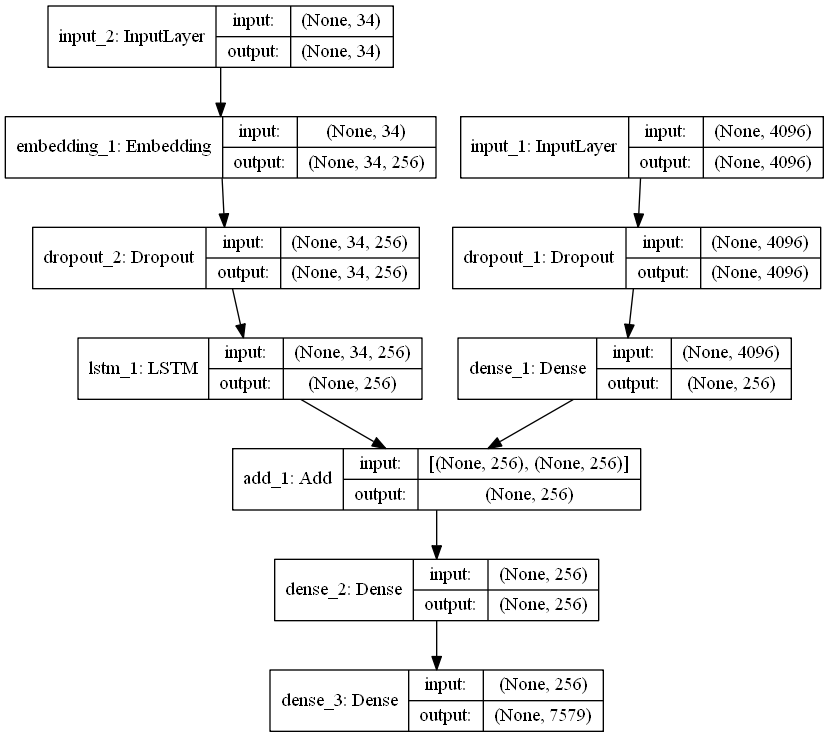

In [36]:
plot_model(model, show_shapes=True)

#### define checkpoint callback

In [37]:
filepath = 'saved_models/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#### fit model

In [38]:
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Instructions for updating:
Use tf.cast instead.
Train on 306404 samples, validate on 50903 samples
Epoch 1/20
 - 1650s - loss: 4.5116 - val_loss: 4.0558

Epoch 00001: val_loss improved from inf to 4.05577, saving model to saved_models/model-ep001-loss4.512-val_loss4.056.h5
Epoch 2/20
 - 1767s - loss: 3.8721 - val_loss: 3.8892

Epoch 00002: val_loss improved from 4.05577 to 3.88918, saving model to saved_models/model-ep002-loss3.872-val_loss3.889.h5
Epoch 3/20
 - 1853s - loss: 3.6857 - val_loss: 3.8540

Epoch 00003: val_loss improved from 3.88918 to 3.85404, saving model to saved_models/model-ep003-loss3.686-val_loss3.854.h5
Epoch 4/20
 - 1714s - loss: 3.5961 - val_loss: 3.8435

Epoch 00004: val_loss improved from 3.85404 to 3.84347, saving model to saved_models/model-ep004-loss3.596-val_loss3.843.h5
Epoch 5/20
 - 1557s - loss: 3.5445 - val_loss: 3.8527

Epoch 00005: val_loss did not improve from 3.84347
Epoch 6/20
 - 1358s - loss: 3.5125 - val_loss: 3.8726

Epoch 00006: val_loss did no

# Evaluate Model

#### map an integer to a word

>word_for_id() in order to map an integer prediction back to a word

In [48]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#### generate a description for an image

>generate_desc() implements this behavior and generates a textual description given a trained model, and a given prepared photo as input

In [47]:
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

#### evaluate the skill of the model

>evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [45]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

>BLEU scores are used in text translation for evaluating translated text against one or more reference translations

In [39]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

### prepare tokenizer on train set

#### load training dataset (6K)

In [33]:
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


#### descriptions

In [34]:
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


#### prepare tokenizer

In [35]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


#### save the tokenizer

In [36]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

#### determine the maximum sequence length

In [38]:
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### prepare test set

#### load test set

In [40]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


#### descriptions

In [41]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


#### photo features

In [42]:
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

Photos: test=1000


#### load the model

In [43]:
filename = 'saved_models/model-ep004-loss3.596-val_loss3.843.h5'
model = load_model(filename)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### evaluate model

In [55]:
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.447931
BLEU-2: 0.233368
BLEU-3: 0.159128
BLEU-4: 0.069781


# Generate New Captions

>We could do this by re-defining the model and adding the VGG-16 model to it, or we can use the VGG model to predict the features and use them as inputs to our existing model. We will do the latter and use a modified version of the extract_features() function used during data preparation, but adapted to work on a single photo

In [31]:
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

In [32]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [34]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [35]:
# pre-define the max sequence length (from training)
max_length = 34

In [36]:
# load the model
model = load_model('saved_models/model-ep004-loss3.596-val_loss3.843.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


startseq black dog is running through the water endseq


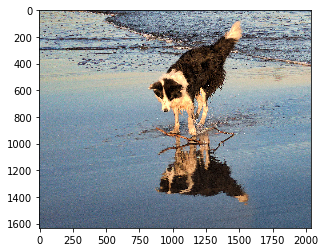

In [39]:
# load and prepare the photograph
photo = extract_features('images_for_description/image1.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
img = Image.open("images_for_description/image1.jpg")
plt.imshow(img)
print(description)

startseq two dogs are playing in the grass endseq


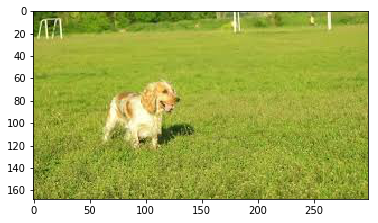

In [44]:
# load and prepare the photograph
photo = extract_features('images_for_description/image2.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
img = Image.open("images_for_description/image2.jpg")
plt.imshow(img)
print(description)